In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA RTX A4500


# Feature Extraction

**Pre-traineded models**

In [2]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.CIFAR10('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.CIFAR10('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


Files already downloaded and verified
Files already downloaded and verified


50000

**OBS: Utilizar CROSS-VALIDATION para DS sem split**

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)


# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.41965526
K score 4 : 0.44148955
K score 5 : 0.47098663
K score 6 : 0.49237818
K score 7 : 0.5135563
K score 8 : 0.54018587
K score 9 : 0.5507663
K score 10 : 0.55894893
K score 11 : 0.5686571
K score 12 : 0.5643546
K score 13 : 0.5592728
K score 14 : 0.54584485
K score 15 : 0.5336346
K score 16 : 0.5143258
K score 17 : 0.49393642
K score 18 : 0.48053306
K score 19 : 0.485181
K score 20 : 0.4676977
K score 21 : 0.45367905
K score 22 : 0.4274799
K score 23 : 0.42526153
K score 24 : 0.40869796
K score 25 : 0.40969703
K score 26 : 0.41055253
K score 27 : 0.40813515
K score 28 : 0.4099901
K score 29 : 0.41221666


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


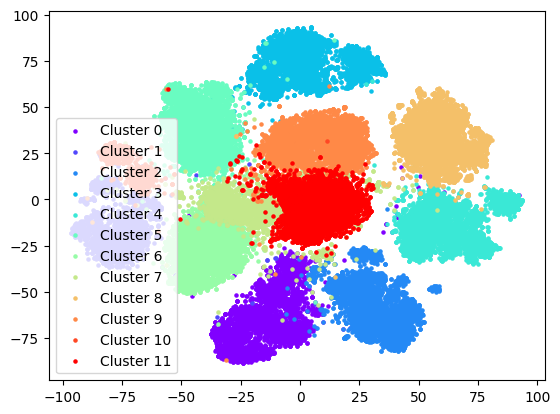

In [4]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 0.2 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=30) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [5]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [6]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [31]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.76082 time: 0.5091173648834229
[3] loss: 0.48853 time: 0.5058081150054932
[4] loss: 0.31142 time: 0.5028715133666992
[5] loss: 0.29389 time: 0.5047626495361328
[6] loss: 0.29375 time: 0.5079383850097656
[7] loss: 0.27465 time: 0.5053575038909912
[8] loss: 0.27725 time: 0.5092606544494629
[9] loss: 0.26009 time: 0.5059311389923096
[10] loss: 0.24666 time: 0.5022923946380615
[11] loss: 0.23828 time: 0.5054481029510498
[12] loss: 0.22575 time: 0.5077028274536133
[13] loss: 0.22715 time: 0.5049083232879639
[14] loss: 0.21704 time: 0.5038411617279053
[15] loss: 0.22010 time: 0.5031778812408447
[16] loss: 0.20336 time: 0.5043141841888428
[17] loss: 0.20018 time: 0.5015764236450195
[18] loss: 0.20378 time: 0.5015945434570312
[19] loss: 0.21455 time: 0.5103018283843994
[20] loss: 0.20572 time: 0.5065362453460693
[21] loss: 0.19794 time: 0.5084407329559326
[22] loss: 0.20002 time: 0.5144941806793213
[23] loss: 0.19078 time: 0.5104358196258545
[24] loss: 0.19926 time: 0.5127184391021

(1000, 52.35520512703806)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


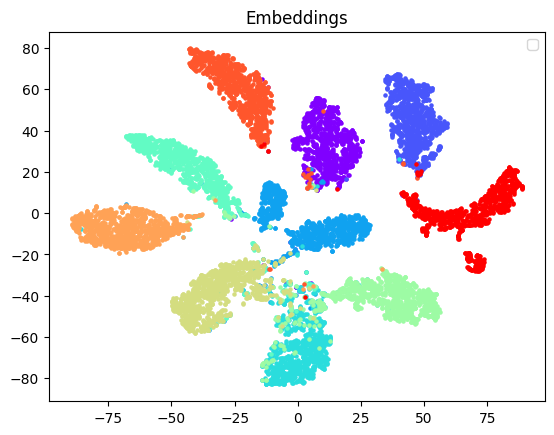

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


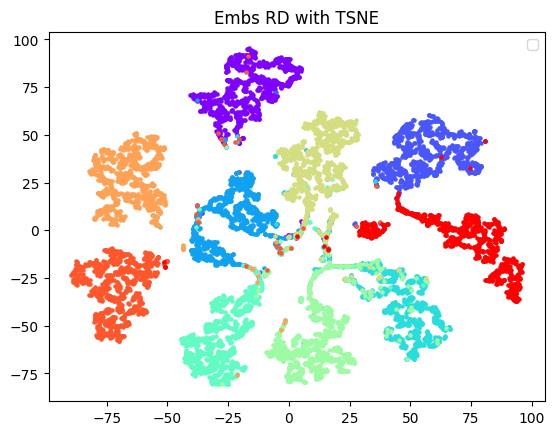

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


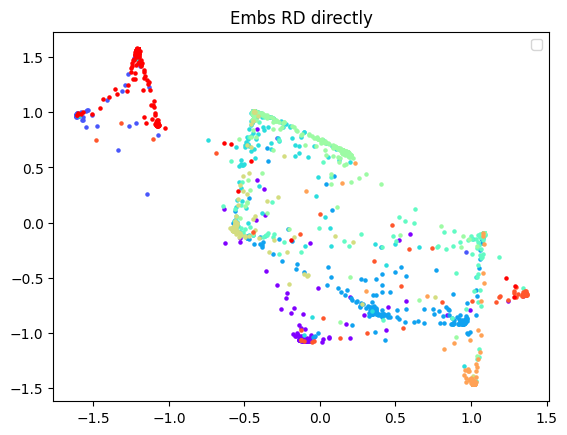

In [33]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [34]:
res = {}

In [35]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = resmap
resmap

Método proposto sem margem moderada


0.8969136909364923

In [7]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 1.04668 time: 0.5005536079406738
[3] loss: 0.67682 time: 0.49175119400024414
[4] loss: 0.56789 time: 0.49211978912353516
[5] loss: 0.49189 time: 0.48927736282348633
[6] loss: 0.44816 time: 0.492046594619751
[7] loss: 0.39007 time: 0.4924023151397705
[8] loss: 0.40061 time: 0.4940347671508789
[9] loss: 0.37884 time: 0.4915740489959717
[10] loss: 0.35194 time: 0.49234533309936523
[11] loss: 0.33794 time: 0.49478793144226074
[12] loss: 0.33755 time: 0.49361610412597656
[13] loss: 0.32598 time: 0.4929957389831543
[14] loss: 0.31351 time: 0.49536705017089844
[15] loss: 0.31229 time: 0.4959375858306885
[16] loss: 0.30194 time: 0.4947514533996582
[17] loss: 0.30190 time: 0.4937758445739746
[18] loss: 0.29063 time: 0.4969522953033447
[19] loss: 0.29326 time: 0.49760007858276367
[20] loss: 0.30289 time: 0.49611330032348633
[21] loss: 0.30447 time: 0.4960653781890869
[22] loss: 0.28810 time: 0.49640440940856934
[23] loss: 0.27846 time: 0.4987373352050781
[24] loss: 0.27426 time: 0.4969

(1000, 73.76969279693377)

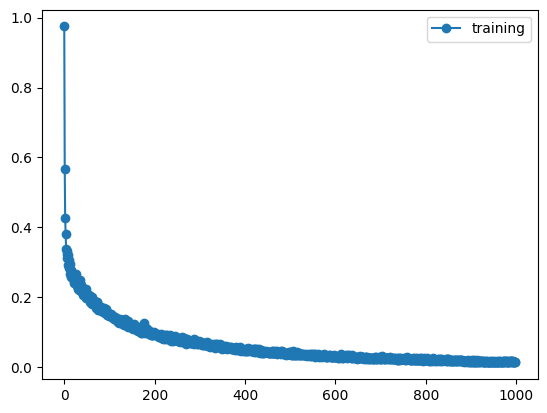

In [39]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


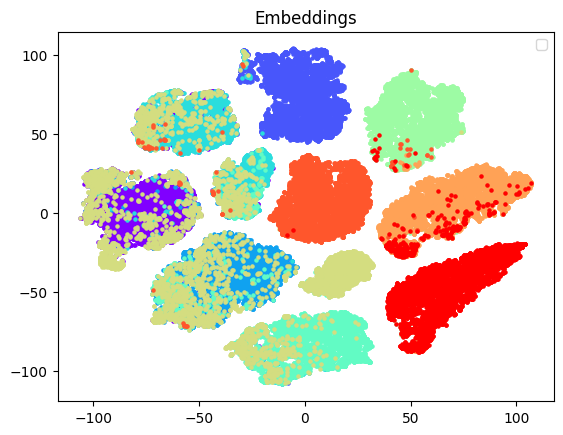

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


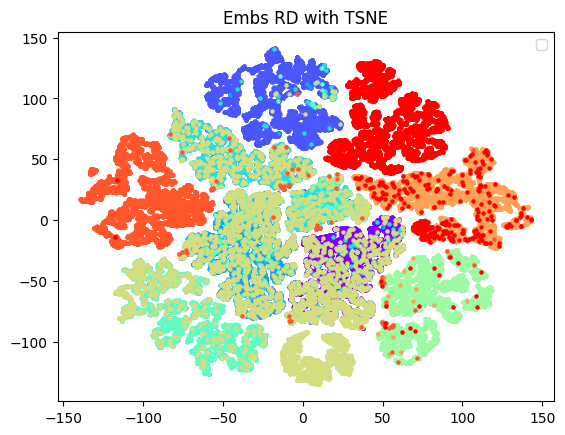

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


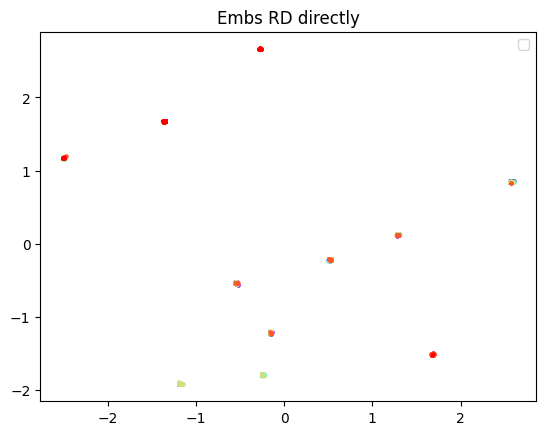

In [27]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


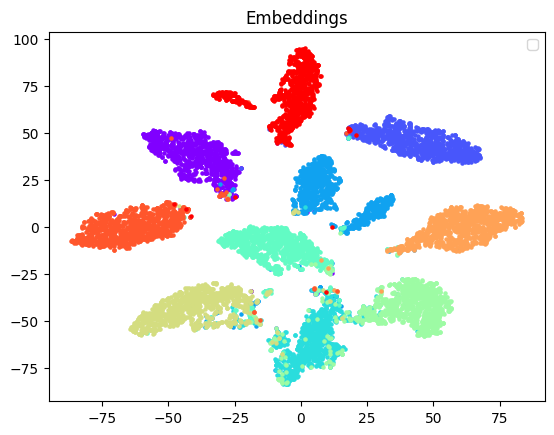

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


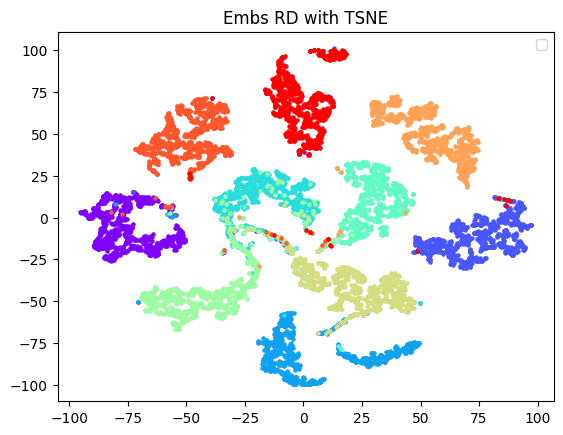

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


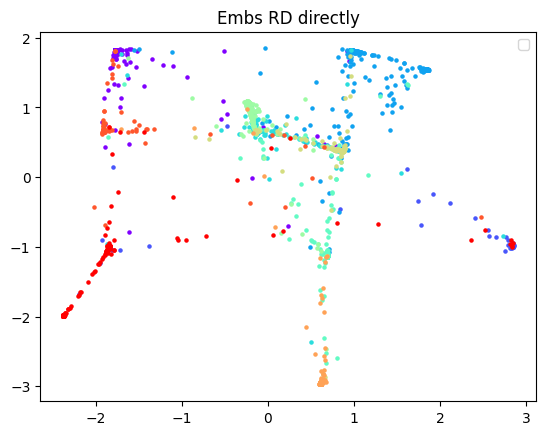

In [41]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [42]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = resmap
resmap

Método proposto


0.9332396588955666

In [43]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = resmap
resmap

Método proposto High Dim


0.9197460774207888

In [44]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = resmap
resmap

Sem projeção


0.6454940620782547

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = resmap
resmap

PCA


0.5357598066245397

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


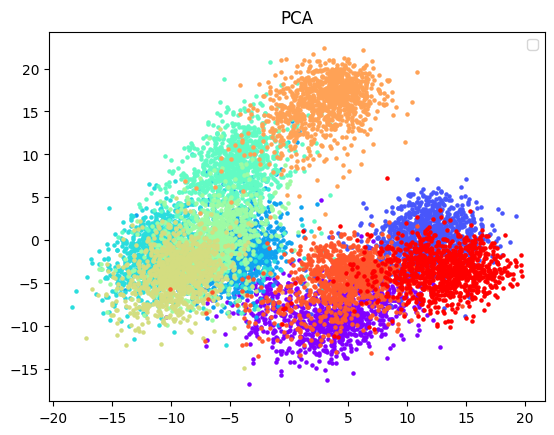

In [52]:
plotsmart(X_pca, lbs, "PCA", True)

In [45]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = resmap
resmap

T-SNE


0.8645192780082148

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


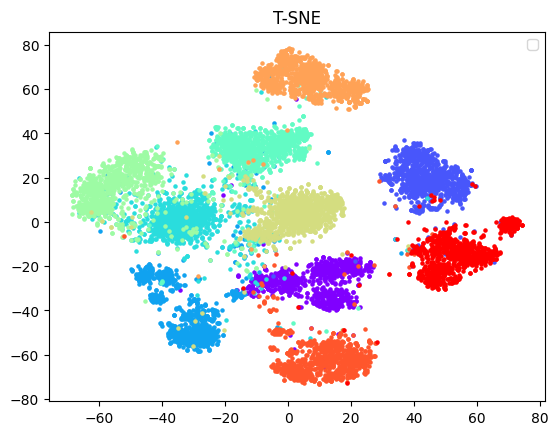

In [13]:
plotsmart(totsne(X), lbs, "T-SNE", True)

In [49]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = resmap
resmap

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP


0.9059425058098579

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


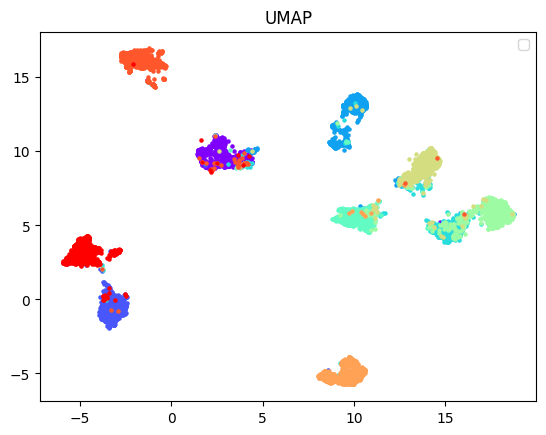

In [50]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [2]:
res

{'ours_not_mg': 0.8969136909364923,
 'ours_with_mg': 0.9332396588955666,
 'ours_with_mg_highdim': 0.9197460774207888,
 'no_projection': 0.6454940620782547,
 'pca': 0.5357598066245397,
 'tsne': 0.8645192780082148,
 'umap': 0.9059425058098579}